# Imports

In [2]:
import sys

sys.path.append("..")
import numpy as np
import plotly.express as px
import plotly.io as pio
from ipywidgets import interact
from scipy.optimize import root_scalar

from calibration.projector.board import draw_board, gen_checkerboard_grid
from calibration.projector.camera import Camera
from calibration.projector.projector import Projector

pio.renderers.default = "svg"

# Backprojection

In [3]:
camera = Camera(135.0, np.array([40, 30]), np.array([1920, 1080]))
w, h = camera.resolution
w, h

(1920, 1080)

## Image plane

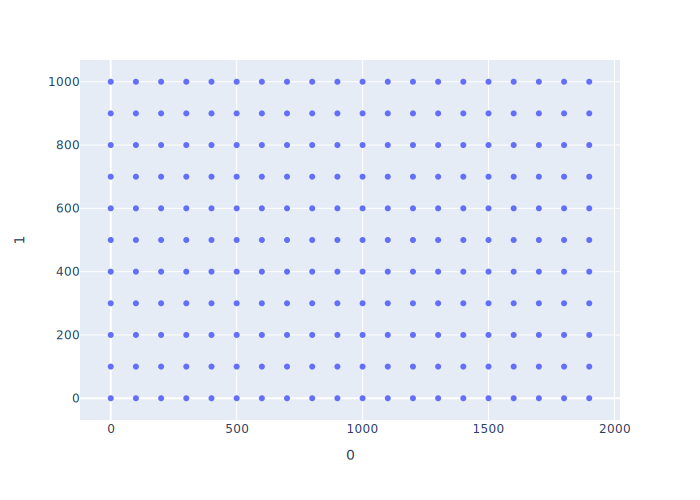

In [4]:
# xs = [[0, 0], [w, 0], [w, h], [0, h]]
xs = [np.array([x, y, 1]) for x in range(0, w + 1, 100) for y in range(0, h + 1, 100)]
xs = [np.array([x, y, 1]) for x in range(0, w, 100) for y in range(0, h, 100)]
xs = [np.array([x, y, 1]) for x in range(0, w + 1, 100) for y in range(0, h + 1, 100)]
xs = np.array(xs)
px.scatter(xs, x=0, y=1)

## Intrinsic

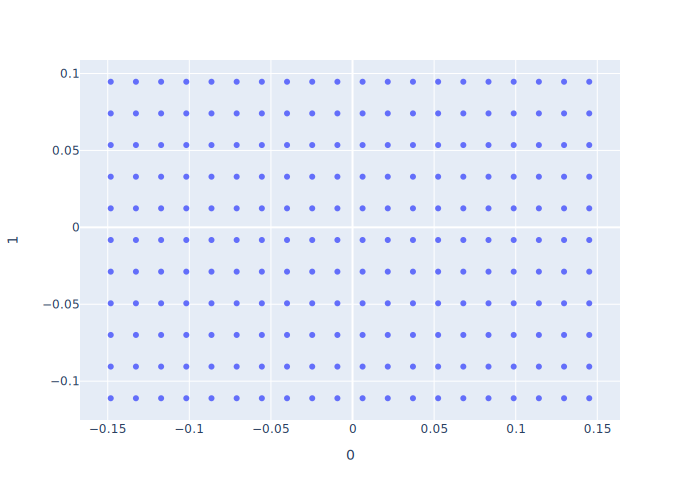

In [5]:
# xs1 = [np.linalg.inv(proj.camera.intrinsic_matrix) @ x for x in xs]
xs1 = (np.linalg.inv(camera.intrinsic_matrix) @ xs.T).T
# xs1 = np.array(xs1)
np.testing.assert_equal(xs1[:, 2], 1)
px.scatter(xs1, x=0, y=1)

## Distortion

In [6]:
def f(l1, l2):
    proj = Projector(lambdas=np.array([l1, l2]))
    xs2 = xs1.copy()
    rs = proj.psi(np.linalg.norm(xs2[:, :2], axis=1))
    xs2[:, 2] = rs
    xs2 /= xs2[:, 2][:, np.newaxis]
    return draw_board(xs2)

In [7]:
interact(f, l1=(-5.0, 5.0), l2=(-10, 10, 0.001));

interactive(children=(FloatSlider(value=0.0, description='l1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

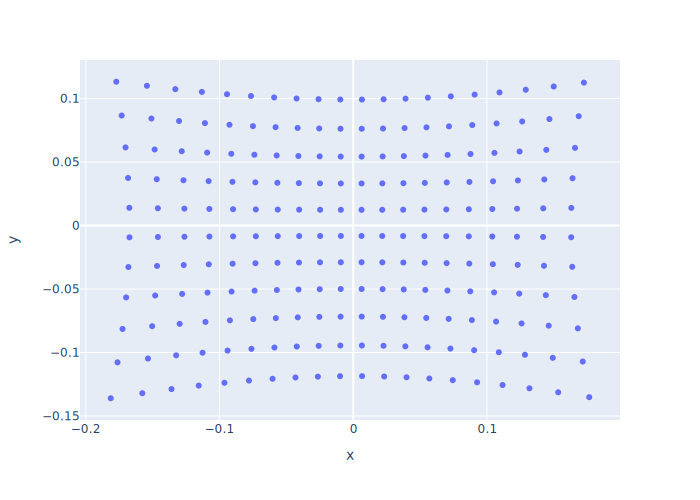

In [8]:
lambdas = np.array([-5, -10])

proj = Projector(lambdas=lambdas, camera=camera)
xs2 = xs1.copy()
psis = proj.psi(np.linalg.norm(xs2[:, :2], axis=1))
xs2[:, 2] = psis
xs2 /= xs2[:, 2][:, np.newaxis]
draw_board(xs2)

## Extrinsics

In [9]:
def f(t3):
    R = np.eye(3)
    t = np.array([t1, t2, t3])
    P = np.c_[R[:, :2], t]
    xs3 = xs2.copy()
    xs3 = (np.linalg.inv(P) @ xs3.T).T
    xs3 /= xs3[:, 2][:, np.newaxis]
    return draw_board(xs3)

In [10]:
interact(f, t1=(-5.0, 5.0), t2=(-5.0, 5.0), t3=(-5.0, 0.01));

interactive(children=(FloatSlider(value=-2.495, description='t3', max=0.01, min=-5.0), Output()), _dom_classes…

In [11]:
R = np.eye(3)
t = [-0.1, -0.1, -2]

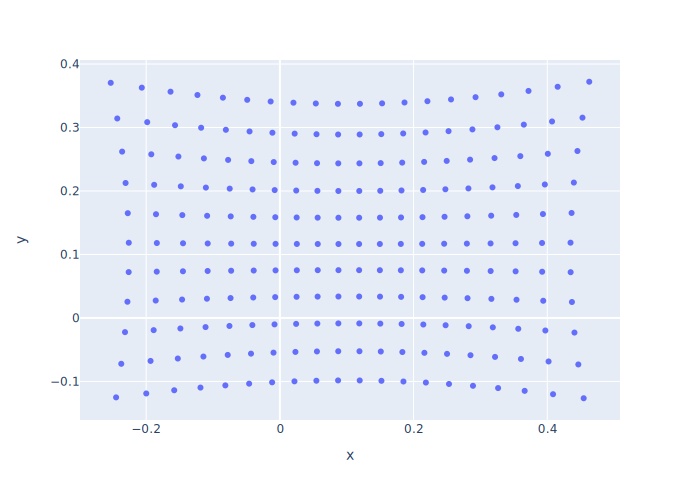

In [12]:
xs3 = xs2.copy()
P = np.c_[R[:, :2], t]
xs3 = (np.linalg.inv(P) @ xs3.T).T
xs3 /= xs3[:, 2][:, np.newaxis]

draw_board(xs3)

# Projection

## Extrinsics

In [13]:
xs3_ = xs3.copy()

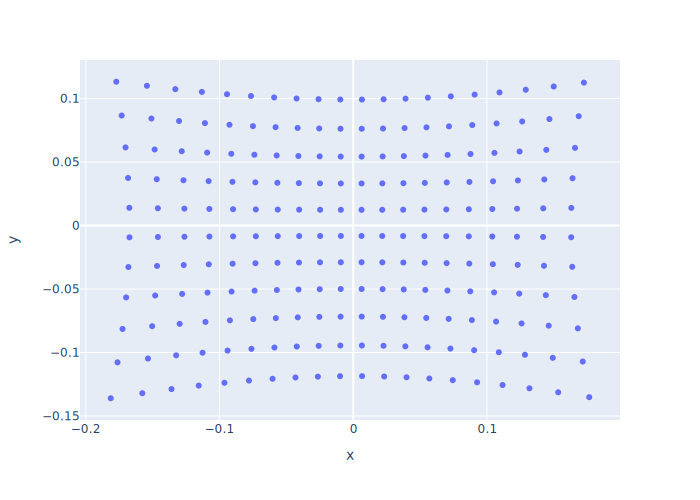

In [14]:
xs2_ = xs3_.copy()
xs2_ = (P @ xs2_.T).T
xs2_ /= xs2_[:, 2][:, np.newaxis]

np.testing.assert_array_almost_equal(xs2, xs2_)
draw_board(xs2_)

## Distortion

In [15]:
def f(r, x):
    # x[2] == 1
    return proj.psi(r) * np.linalg.norm(x[:2]) - r


max_point_img_space = np.r_[proj.camera.resolution, 1]
max_point = np.linalg.inv(proj.camera.intrinsic_matrix) @ max_point_img_space
max_r = np.linalg.norm(max_point[:2]) + 0.1

In [16]:
max_r = 1000

In [17]:
xs1_ = xs2_.copy()
assert (xs1_[:, 2] == 1).all()
idx = np.linalg.norm(xs1_[:, :2], axis=1) > np.finfo(float).eps

eps = np.finfo(np.float64).eps
rs_ = np.array(
    # [root_scalar(f, args=(xi,), bracket=(0, max_r * 1.1)).root for xi in xs1_[idx]]
    [root_scalar(f, args=(xi,), bracket=(0, max_r)).root for xi in xs1_[idx]]
)
xs1_[idx] *= (rs_ / np.linalg.norm(xs1_[idx, :2], axis=1))[:, np.newaxis]
np.testing.assert_almost_equal(
    proj.psi(np.linalg.norm(xs1_[idx, :2], axis=1)), xs1_[idx, 2], decimal=5
)

# xs1_[idx] *= (rs_ /  np.linalg.norm(xs1_[:, :2], axis=1)[idx])[:, np.newaxis]
xs1_[:, 2] = 1

np.testing.assert_array_almost_equal(xs1, xs1_)

In [18]:
rs_.max()

0.1851851851851852

## Intrinsic matrix

In [19]:
xs_ = xs1_.copy()

xs_ = (proj.camera.intrinsic_matrix @ xs_.T).T
# Pyright bug
xs_ /= xs_[:, 2][:, None]  # type: ignore
np.testing.assert_array_almost_equal(xs, xs_)
# draw_board(xs_)

# Projector

In [28]:
@interact
def f(
    t1=(-5.0, 5.0), t2=(-5.0, 5.0), t3=(0.01, 15), l1=(-5.0, 5.0), l2=(-10, 10, 0.001)
):
    R = np.eye(3)
    t = np.array([t1, t2, t3])
    # Camera(135.0, np.array([40, 30]), np.array([1920, 1080]))
    proj = Projector(R=R, t=t, lambdas=np.array([l1, l2]))  # , camera=camera)
    print(
        f"l2 = [{-2.61752136752137 * l1 - 6.85141810943093}, {-2.61752136752137 * l1 - 4.39190876941320}]"
    )

    X = gen_checkerboard_grid(7, 9)
    X -= X.max(axis=0)
    x = proj.project(X)
    return px.scatter(x, x=0, y=1)

interactive(children=(FloatSlider(value=0.0, description='t1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…